# 1-异常检测算法
## 案例：检测异常服务器
### 数据集：ex8data1.mat

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

In [2]:
mat = sio.loadmat('ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X,Xval,yval = mat['X'],mat['Xval'],mat['yval']
X.shape,Xval.shape,yval.shape

((307, 2), (307, 2), (307, 1))

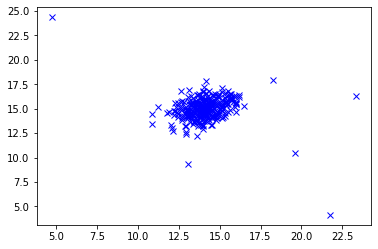

In [4]:
plt.plot(X[:,0],X[:,1],'bx')
plt.show()

### 1.获取训练集样本特征的均值和方差

In [5]:
def estimateGaussian(X,isCovariance):
    """高斯分布参数估计"""
    means = np.mean(X,axis=0)
    
    if isCovariance:
        # 求协方差
        sigma2 = (X - means).T @ (X - means) / len(X)
    else:
        # 求方差
        sigma2 = np.var(X,axis=0)
        
    return means,sigma2

In [6]:
means,sigma2 = estimateGaussian(X,isCovariance=True)
sigma2

array([[ 1.83263141, -0.22712233],
       [-0.22712233,  1.70974533]])

In [7]:
means,sigma2 = estimateGaussian(X,isCovariance=False)
sigma2

array([1.83263141, 1.70974533])

### 2.多元正态分布密度函数

In [10]:
def gaussian(X,means,sigma2):
    
    if np.ndim(sigma2) == 1:
        sigma2 = np.diag(sigma2)
        
    X = X - means
    n = X.shape[1]
    
    p = np.power(2*np.pi,-n/2) * (np.linalg.det(sigma2)**(-0.5)) * np.exp(-0.5*np.diag(X@np.linalg.inv(sigma2)@X.T))
    p = p.reshape(-1,1)
    
    return p 

### 3.绘图

In [13]:
def plotGaussian(X,means,sigma2):
    x = np.arange(0,30,0.5)
    y = np.arange(0,30,0.5)
    xx,yy = np.meshgrid(x,y)
    z = gaussian(np.c_[xx.ravel(),yy.ravel()],means,sigma2)
    zz = z.reshape(xx.shape)
    plt.plot(X[:,0],X[:,1],'bx')
    contour_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx,yy,zz,contour_levels)

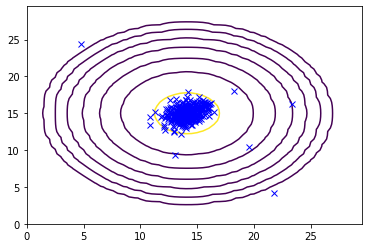

In [14]:
means,sigma2 = estimateGaussian(X,isCovariance=False)
plotGaussian(X,means,sigma2)

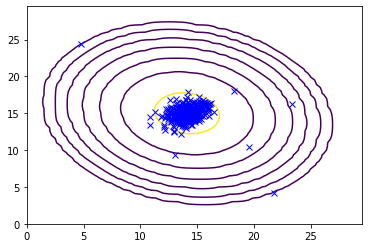

In [15]:
means,sigma2 = estimateGaussian(X,isCovariance=True)
plotGaussian(X,means,sigma2)

### 4.epsilon选取

In [18]:
def selectThreshold(yval,p):
    bestEpsilon = 0
    bestF1 = 0
    epsilons = np.linspace(min(p),max(p),1000)
    
    for e in epsilons:
        p_ = p < e
        tp = np.sum((yval==1)&(p_==1))
        fp = np.sum((yval==0)&(p_==1))
        fn = np.sum((yval==1)&(p_==0))
        
        prec = tp / (tp+fp) if (tp+fp) else 0
        rec = tp / (tp+fn) if (tp+fn) else 0
        F1_e = 2 * prec * rec / (prec + rec) if (prec + rec) else 0 
        
        if F1_e > bestF1:
            bestF1 = F1_e
            bestEpsilon = e
            
    return bestEpsilon,bestF1

In [19]:
means,sigma2 = estimateGaussian(X,isCovariance=True)
pval = gaussian(Xval,means,sigma2)
bestEpsilon,bestF1 = selectThreshold(yval,pval)

In [20]:
bestEpsilon,bestF1

(array([9.07484457e-05]), 0.8750000000000001)

In [21]:
means,sigma2 = estimateGaussian(X,isCovariance=False)
pval = gaussian(Xval,means,sigma2)
bestEpsilon,bestF1 = selectThreshold(yval,pval)
bestEpsilon,bestF1

(array([8.99985263e-05]), 0.8750000000000001)

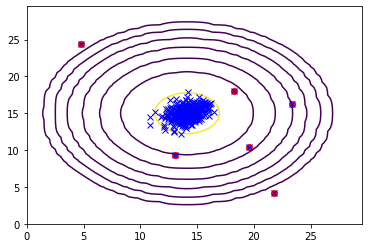

In [22]:
p = gaussian(X,means,sigma2)
anorms = np.array([X[i] for i in range(X.shape[0]) if p[i] < bestEpsilon])
plotGaussian(X,means,sigma2)
plt.scatter(anorms[:,0],anorms[:,1],c='r',marker='o')